# Cointegration Experiment
This is a proof of concept for selecting pairs of stocks that are cointegrated. Note that this requires an API key, so follow the instructions in the README to get one.
**This notebook relies on the scripts in the src folder.**

In [ ]:
import os
import sys
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime, timedelta
from datetime import time
from src.util import (
    eastern,
    BarUtils,
)
from utilities.plotting import plot_price_data, plt_show, plot_split_dataframe
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import seaborn as sns
from itertools import combinations
from tqdm import tqdm

load_dotenv()

ALPACA_API_KEY = os.getenv("ALPACA_API_KEY")
ALPACA_API_SECRET = os.getenv("ALPACA_API_SECRET")
DATA_DIR = "data"
DEFAULT_FIGSIZE = (15, 10)

Define the tickers and timeframes.

In [ ]:
utility_tickers = [
    "NEE", "EXC", "D", "PCG", "XEL", 
    "ED", "WEC", "DTE", "PPL", "AEE", 
    "CNP", "FE", "CMS", "EIX", "ETR", 
    "EVRG", "LNT", "PNW", "IDA", "AEP", 
    "DUK", "SRE", "ATO", "NRG",
]
refresh_bars = False # set to true to refresh the bars. this requires the alpaca api key and secret to be set in the .env file
start_date = datetime(2024, 6, 1)
end_date = datetime.today() - timedelta(minutes=15)
timeframe = TimeFrame.Hour

Load the data.

Loading data/utility_bars.pkl
Loading data/utility_close_prices.pkl


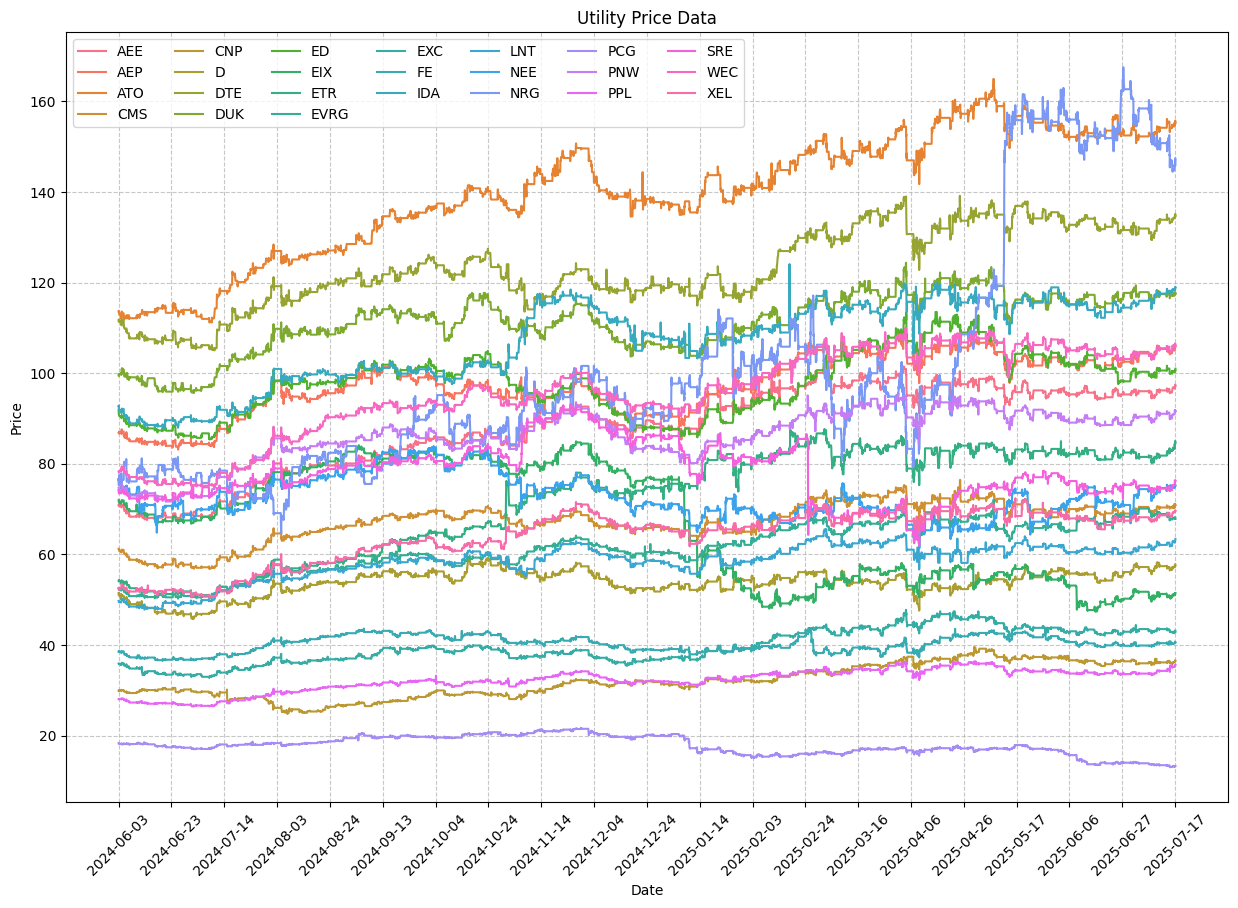

In [3]:
client = StockHistoricalDataClient(
    api_key=ALPACA_API_KEY, secret_key=ALPACA_API_SECRET
)
request_params = StockBarsRequest(
    symbol_or_symbols=utility_tickers,
    timeframe=timeframe,
    start=start_date,
    end=end_date,
    adjustment="all",
)

if refresh_bars:
    bars = client.get_stock_bars(request_params).df  # get the bars
    save_dataframe(bars, "utility_bars")  # save the bars
    bars = load_dataframe("utility_bars")  # load the bars
    # convert all the dates to est. this is a multi-index dataframe, so we need to convert the index
    bars.index = bars.index.map(lambda x: (x[0], x[1].astimezone(eastern)))
    # resample the bars. apply to each ticker
    bars = BarUtils.resample_multi_ticker_bars(bars)
    save_dataframe(bars, "utility_bars_resampled")
    # get the close prices
    close_prices = bars["close"].unstack(level=0)
    save_dataframe(close_prices, "utility_close_prices")

# load them from the data directory
close_prices = load_dataframe("utility_close_prices", DATA_DIR)
plot_price_data(close_prices, "Utility Price Data")
plt_show(prefix="utility_price_data")


## Analyze the relationship between prices
For selection, we take the spread (price difference) over all combinations of two tickers. In order for a pairs trading strategy to work, the prices in a pair must be cointegrated. We use the Johansen test for that.

In [4]:
tt_split = 0.9 # 80% of the data is used for training

# we want the strategy to train on
train_prices = close_prices.iloc[:int(tt_split * len(close_prices))]
test_prices = close_prices.iloc[int(tt_split * len(close_prices)):]
print(f"Train prices: {train_prices.shape}")
print(f"Test prices: {test_prices.shape}")

Train prices: (8841, 24)
Test prices: (983, 24)


Engle Granger test

In [5]:
cointegration_results = pd.DataFrame(columns=["p-value", "primary_mean", "secondary_mean"])
for primary, secondary in tqdm(combinations(utility_tickers, 2)):
    # make identifie, alphabetically sorted
    pair = tuple(sorted([primary, secondary]))
    if pair in cointegration_results:
        continue

    # normalize the prices amd calculate the spread
    primary_mean = train_prices[primary].mean()
    secondary_mean = train_prices[secondary].mean()

    spread = train_prices[primary] / train_prices[secondary]

    # calculate how stationary the spread is
    spread_pvalue = adfuller(spread, maxlag=0)[1]

    cointegration_results = pd.concat([cointegration_results, pd.DataFrame({"p-value": spread_pvalue, "primary_mean": primary_mean, "secondary_mean": secondary_mean}, index=[pair])])

0it [00:00, ?it/s]/tmp/ipykernel_4225/2165633357.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cointegration_results = pd.concat([cointegration_results, pd.DataFrame({"p-value": spread_pvalue, "primary_mean": primary_mean, "secondary_mean": secondary_mean}, index=[pair])])
276it [00:00, 671.76it/s]


Sort pairs by results and take the lowest 10 values. 

In [6]:
# sort by p-value
cointegration_results = cointegration_results.sort_values(by="p-value").head(10)
print(cointegration_results)


                  p-value  primary_mean  secondary_mean
(EVRG, PPL)  2.071894e-11     31.977201       60.630266
(IDA, XEL)   1.220218e-10     63.491541      106.072749
(EVRG, IDA)  6.172142e-10     60.630266      106.072749
(IDA, PPL)   7.894461e-08     31.977201      106.072749
(ATO, IDA)   2.835939e-07    106.072749      138.353284
(AEP, DUK)   1.153331e-06     96.822764      110.642389
(LNT, PNW)   1.155609e-06     58.076936       85.897402
(CMS, DUK)   1.487442e-06     66.965465      110.642389
(CMS, PNW)   1.594545e-06     66.965465       85.897402
(ATO, WEC)   3.098857e-06     94.753515      138.353284


Pick the top pair and plot the residual adjusted by alpha and beta.

8841 983


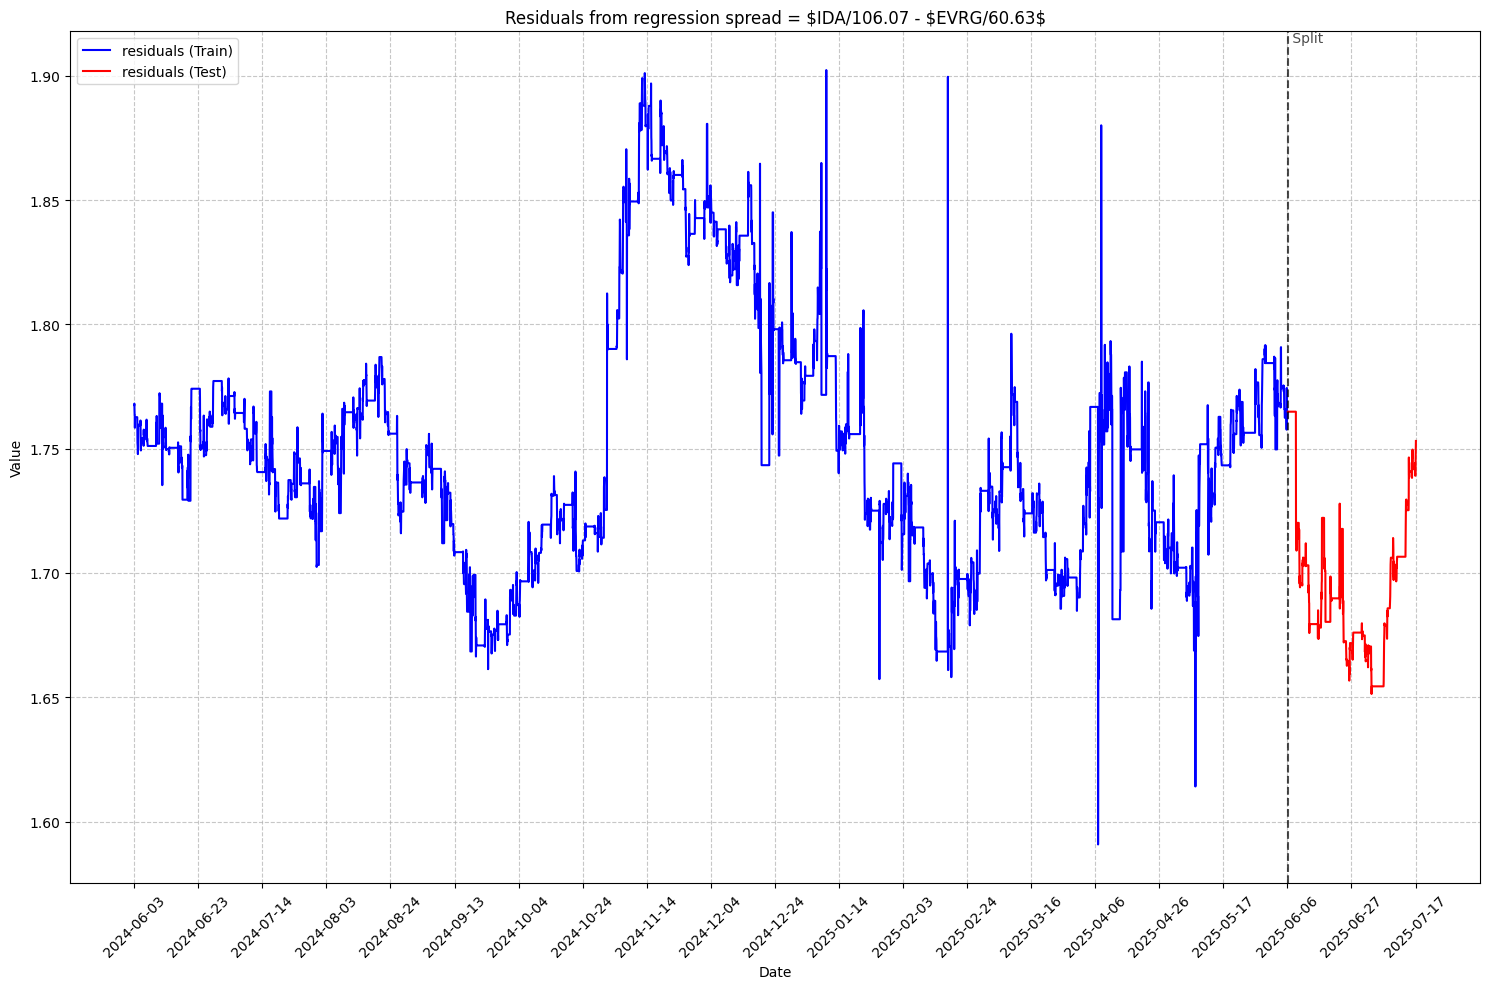

In [7]:
best = cointegration_results.iloc[2]
primary, secondary = best.name
primary_mean, secondary_mean = best["primary_mean"], best["secondary_mean"]
# calculate the residuals for train and test
residuals_train = train_prices[secondary] / train_prices[primary]
residuals_test = test_prices[secondary] / test_prices[primary]

print(len(residuals_train), len(residuals_test))

# combine the residuals into a single dataframe
combined_residuals = pd.DataFrame(pd.concat([residuals_train, residuals_test]), columns=["residuals"])

# plot the residuals
plot_split_dataframe(combined_residuals, len(train_prices), title=rf"Residuals from regression spread = ${secondary}/{secondary_mean:.2f} - ${primary}/{primary_mean:.2f}$")
plt_show(prefix="residuals")

We use a rolling beta to determine spread pricing
https://github.com/quantrocket-codeload/quant-finance-lectures/blob/master/quant_finance_lectures/Lecture42-Introduction-to-Pairs-Trading.ipynb